<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/MRtoCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MR to CT

## Step 1: Setup the Environment

In [1]:
# Install required libraries
!pip install datasets

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

## Step 2: Load and Preprocess the MRI Dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

(…)-00000-of-00001-c08a401c53fe5312.parquet:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

(…)-00000-of-00001-44110b9df98c5585.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

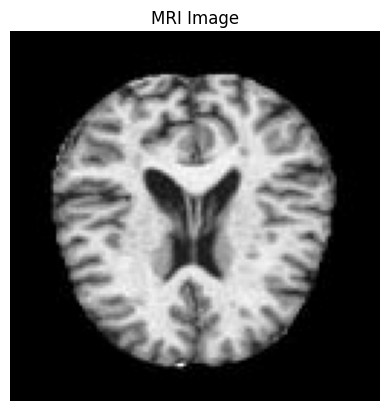

In [2]:
# Load the MRI dataset
mri_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 (as per the paper's input size)
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (grayscale, so 1 channel)
])

# Custom Dataset class for MRI only
class MRIDataset(Dataset):
    def __init__(self, mri_dataset, transform=None):
        self.mri_dataset = mri_dataset
        self.transform = transform

    def __len__(self):
        return len(self.mri_dataset)

    def __getitem__(self, idx):
        mri_image = self.mri_dataset[idx]['image']  # Adjust key if needed
        if not isinstance(mri_image, Image.Image):
            mri_image = Image.fromarray(np.array(mri_image))

        if self.transform:
            mri_image = self.transform(mri_image)

        return mri_image

# Create dataset and dataloader
dataset = MRIDataset(mri_dataset, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Visualize a sample
mri_img = dataset[0]
plt.imshow(mri_img.squeeze(), cmap='gray')
plt.title("MRI Image")
plt.axis('off')
plt.show()

## Step 3: Define the cGAN Generator and Discriminator

In [3]:
# Residual Block (same as in the paper)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection

# cGAN Generator (MRI -> CT)
class cGANGenerator(nn.Module):
    def __init__(self):
        super(cGANGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.res_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(9)])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.decoder(x)
        return x

# cGAN Discriminator
class cGANDiscriminator(nn.Module):
    def __init__(self):
        super(cGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),  # Input: MRI + Generated CT
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, mri, ct):
        x = torch.cat([mri, ct], dim=1)  # Concatenate MRI and CT along channel dimension
        return self.model(x)

# Initialize models
G = cGANGenerator().to(device)
D = cGANDiscriminator().to(device)

## Step 4: Define Loss Functions and Optimizers

In [6]:
# Loss functions
adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# Heuristic losses for CT-like features
def edge_loss(fake_ct):
    # Apply Sobel filter to emphasize edges (CT images highlight bone structures)
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).to(device)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).to(device)
    sobel_x = sobel_x.view(1, 1, 3, 3)
    sobel_y = sobel_y.view(1, 1, 3, 3)

    edge_x = F.conv2d(fake_ct, sobel_x, padding=1)
    edge_y = F.conv2d(fake_ct, sobel_y, padding=1)
    edges = torch.sqrt(edge_x**2 + edge_y**2)
    return -torch.mean(edges)  # Encourage more edges (negative to maximize)

def contrast_loss(fake_ct):
    # Encourage high contrast (CT images have high contrast between bone and soft tissue)
    mean = torch.mean(fake_ct, dim=(2, 3), keepdim=True)
    variance = torch.mean((fake_ct - mean)**2, dim=(2, 3))
    return -torch.mean(variance)  # Encourage higher variance (negative to maximize)

# Optimizers
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Labels for adversarial loss (match Discriminator output size: [batch_size, 1, 14, 14])
# We'll define these dynamically in the training loop to handle varying batch sizes

## Step 5: Training Loop

In [8]:
# Training Loop
num_epochs = 5
lambda_edge = 10.0
lambda_contrast = 5.0

for epoch in range(num_epochs):
    for i, mri_images in enumerate(dataloader):
        mri_images = mri_images.to(device)
        batch_size = mri_images.size(0)  # Get the current batch size

        # Define labels dynamically to match Discriminator output size
        real_label = torch.ones((batch_size, 1, 14, 14)).to(device)  # Match Discriminator output: [batch_size, 1, 14, 14]
        fake_label = torch.zeros((batch_size, 1, 14, 14)).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Fake images
        fake_ct = G(mri_images)
        fake_pred = D(mri_images, fake_ct.detach())
        loss_D_fake = adversarial_loss(fake_pred, fake_label)

        # Since we don't have real CT, we'll use a heuristic "real" CT by transforming MRI
        with torch.no_grad():
            sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).to(device)
            sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).to(device)
            sobel_x = sobel_x.view(1, 1, 3, 3)
            sobel_y = sobel_y.view(1, 1, 3, 3)
            edge_x = F.conv2d(mri_images, sobel_x, padding=1)
            edge_y = F.conv2d(mri_images, sobel_y, padding=1)
            pseudo_ct = torch.sqrt(edge_x**2 + edge_y**2)
            pseudo_ct = torch.tanh(pseudo_ct)  # Normalize to [-1, 1]

        real_pred = D(mri_images, pseudo_ct)
        loss_D_real = adversarial_loss(real_pred, real_label)

        # Total Discriminator Loss
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        fake_ct = G(mri_images)
        fake_pred = D(mri_images, fake_ct)
        loss_G_adv = adversarial_loss(fake_pred, real_label)
        loss_G_edge = edge_loss(fake_ct)
        loss_G_contrast = contrast_loss(fake_ct)

        # Total Generator Loss
        loss_G = loss_G_adv + lambda_edge * loss_G_edge + lambda_contrast * loss_G_contrast
        loss_G.backward()
        optimizer_G.step()

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                  f"Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")

    # Save models
    torch.save(G.state_dict(), f'cGAN_G_epoch_{epoch+1}.pth')

Epoch [1/5] Batch [0/1280] Loss_D: 0.0010 Loss_G: -76.3344
Epoch [1/5] Batch [50/1280] Loss_D: 0.0006 Loss_G: -76.5042
Epoch [1/5] Batch [100/1280] Loss_D: 0.0005 Loss_G: -76.2578
Epoch [1/5] Batch [150/1280] Loss_D: 0.0004 Loss_G: -75.9869
Epoch [1/5] Batch [200/1280] Loss_D: 0.0003 Loss_G: -75.7691
Epoch [1/5] Batch [250/1280] Loss_D: 0.0002 Loss_G: -75.6375
Epoch [1/5] Batch [300/1280] Loss_D: 0.0002 Loss_G: -75.5047
Epoch [1/5] Batch [350/1280] Loss_D: 0.0002 Loss_G: -75.3415
Epoch [1/5] Batch [400/1280] Loss_D: 0.0001 Loss_G: -75.2132
Epoch [1/5] Batch [450/1280] Loss_D: 0.0001 Loss_G: -75.0680
Epoch [1/5] Batch [500/1280] Loss_D: 0.0001 Loss_G: -74.9539
Epoch [1/5] Batch [550/1280] Loss_D: 0.0001 Loss_G: -74.8735
Epoch [1/5] Batch [600/1280] Loss_D: 0.0001 Loss_G: -74.7916
Epoch [1/5] Batch [650/1280] Loss_D: 0.0001 Loss_G: -74.6320
Epoch [1/5] Batch [700/1280] Loss_D: 0.0001 Loss_G: -74.5880
Epoch [1/5] Batch [750/1280] Loss_D: 0.0001 Loss_G: -74.4924
Epoch [1/5] Batch [800/1280

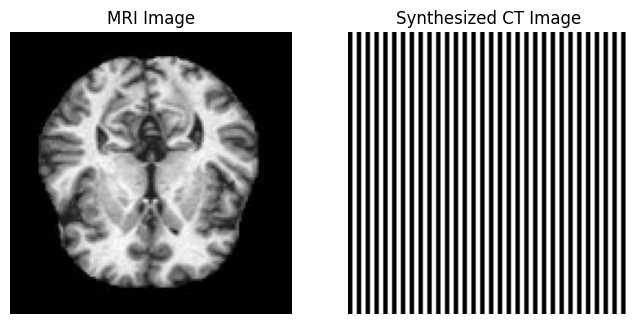

In [9]:
# Test the Generator
G.eval()
with torch.no_grad():
    mri_images = next(iter(dataloader))
    mri_images = mri_images.to(device)
    fake_ct = G(mri_images)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(mri_images[0].cpu().squeeze(), cmap='gray')
    plt.title("MRI Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(fake_ct[0].cpu().squeeze(), cmap='gray')
    plt.title("Synthesized CT Image")
    plt.axis('off')
    plt.show()

# New

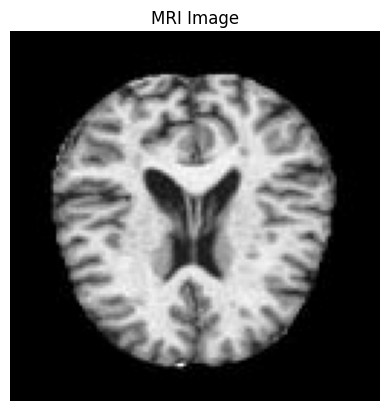

In [10]:
# Load the MRI dataset
mri_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (grayscale, so 1 channel)
])

# Custom Dataset class for MRI only
class MRIDataset(Dataset):
    def __init__(self, mri_dataset, transform=None):
        self.mri_dataset = mri_dataset
        self.transform = transform

    def __len__(self):
        return len(self.mri_dataset)

    def __getitem__(self, idx):
        mri_image = self.mri_dataset[idx]['image']  # Adjust key if needed
        if not isinstance(mri_image, Image.Image):
            mri_image = Image.fromarray(np.array(mri_image))

        if self.transform:
            mri_image = self.transform(mri_image)

        return mri_image

# Create dataset and dataloader
dataset = MRIDataset(mri_dataset, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Visualize a sample
mri_img = dataset[0]
plt.imshow(mri_img.squeeze(), cmap='gray')
plt.title("MRI Image")
plt.axis('off')
plt.show()

In [11]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection

# cGAN Generator (MRI -> CT)
class cGANGenerator(nn.Module):
    def __init__(self):
        super(cGANGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.res_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(9)])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.decoder(x)
        return x

# cGAN Discriminator
class cGANDiscriminator(nn.Module):
    def __init__(self):
        super(cGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),  # Input: MRI + Generated CT
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, mri, ct):
        x = torch.cat([mri, ct], dim=1)  # Concatenate MRI and CT along channel dimension
        return self.model(x)

# Initialize models
G = cGANGenerator().to(device)
D = cGANDiscriminator().to(device)

In [12]:
# Loss functions
adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# Heuristic losses for CT-like features
def edge_loss(fake_ct):
    # Apply Sobel filter to emphasize edges (CT images highlight bone structures)
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).to(device)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).to(device)
    sobel_x = sobel_x.view(1, 1, 3, 3)
    sobel_y = sobel_y.view(1, 1, 3, 3)

    edge_x = F.conv2d(fake_ct, sobel_x, padding=1)
    edge_y = F.conv2d(fake_ct, sobel_y, padding=1)
    edges = torch.sqrt(edge_x**2 + edge_y**2)
    return -torch.mean(edges)  # Encourage more edges (negative to maximize)

def contrast_loss(fake_ct):
    # Encourage high contrast (CT images have high contrast between bone and soft tissue)
    mean = torch.mean(fake_ct, dim=(2, 3), keepdim=True)
    variance = torch.mean((fake_ct - mean)**2, dim=(2, 3))
    return -torch.mean(variance)  # Encourage higher variance (negative to maximize)

def smoothness_loss(fake_ct):
    # Penalize repetitive patterns like stripes by encouraging smoothness in non-edge areas
    diff_x = fake_ct[:, :, :, 1:] - fake_ct[:, :, :, :-1]
    diff_y = fake_ct[:, :, 1:, :] - fake_ct[:, :, :-1, :]
    return torch.mean(torch.abs(diff_x)) + torch.mean(torch.abs(diff_y))  # Minimize differences (encourage smoothness)

# Optimizers
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
# Training Loop
num_epochs = 1  # Increased epochs for better learning
lambda_edge = 5.0  # Reduced weight
lambda_contrast = 2.0  # Reduced weight
lambda_smoothness = 1.0  # New smoothness loss weight

for epoch in range(num_epochs):
    for i, mri_images in enumerate(dataloader):
        mri_images = mri_images.to(device)
        batch_size = mri_images.size(0)

        # Define labels with label smoothing
        real_label = torch.full((batch_size, 1, 14, 14), 0.9).to(device)  # Label smoothing: 0.9 instead of 1
        fake_label = torch.full((batch_size, 1, 14, 14), 0.1).to(device)  # Label smoothing: 0.1 instead of 0

        # Train Discriminator (train twice per iteration for stability)
        for _ in range(2):
            optimizer_D.zero_grad()

            # Fake images
            fake_ct = G(mri_images)
            fake_pred = D(mri_images, fake_ct.detach())
            loss_D_fake = adversarial_loss(fake_pred, fake_label)

            # Improved pseudo-CT: Edge detection + intensity thresholding to mimic bone structures
            with torch.no_grad():
                # Edge detection
                sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).to(device)
                sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).to(device)
                sobel_x = sobel_x.view(1, 1, 3, 3)
                sobel_y = sobel_y.view(1, 1, 3, 3)
                edge_x = F.conv2d(mri_images, sobel_x, padding=1)
                edge_y = F.conv2d(mri_images, sobel_y, padding=1)
                edges = torch.sqrt(edge_x**2 + edge_y**2)
                # Intensity thresholding to mimic bone (high intensity in CT)
                pseudo_ct = torch.where(mri_images > 0.5, edges, mri_images * 0.2)  # Highlight high-intensity areas
                pseudo_ct = torch.tanh(pseudo_ct)  # Normalize to [-1, 1]

            real_pred = D(mri_images, pseudo_ct)
            loss_D_real = adversarial_loss(real_pred, real_label)

            # Total Discriminator Loss
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        fake_ct = G(mri_images)
        fake_pred = D(mri_images, fake_ct)
        loss_G_adv = adversarial_loss(fake_pred, real_label)
        loss_G_edge = edge_loss(fake_ct)
        loss_G_contrast = contrast_loss(fake_ct)
        loss_G_smoothness = smoothness_loss(fake_ct)

        # Total Generator Loss
        loss_G = loss_G_adv + lambda_edge * loss_G_edge + lambda_contrast * loss_G_contrast + lambda_smoothness * loss_G_smoothness
        loss_G.backward()
        optimizer_G.step()

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                  f"Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")

    # Save models
    torch.save(G.state_dict(), f'cGAN_G_epoch_{epoch+1}.pth')

Epoch [1/1] Batch [0/1280] Loss_D: 1.1302 Loss_G: -4.6156
Epoch [1/1] Batch [50/1280] Loss_D: 0.3261 Loss_G: -37.6956
Epoch [1/1] Batch [100/1280] Loss_D: 0.3256 Loss_G: -38.1483
Epoch [1/1] Batch [150/1280] Loss_D: 0.3254 Loss_G: -38.2460
Epoch [1/1] Batch [200/1280] Loss_D: 0.3253 Loss_G: -38.3307
Epoch [1/1] Batch [250/1280] Loss_D: 0.3253 Loss_G: -38.4712
Epoch [1/1] Batch [300/1280] Loss_D: 0.3252 Loss_G: -38.4767
Epoch [1/1] Batch [350/1280] Loss_D: 0.3252 Loss_G: -38.4863
Epoch [1/1] Batch [400/1280] Loss_D: 0.3252 Loss_G: -38.4918
Epoch [1/1] Batch [450/1280] Loss_D: 0.3252 Loss_G: -38.4825
Epoch [1/1] Batch [500/1280] Loss_D: 0.3263 Loss_G: -38.4372
Epoch [1/1] Batch [550/1280] Loss_D: 0.3251 Loss_G: -38.4769
Epoch [1/1] Batch [600/1280] Loss_D: 0.3254 Loss_G: -38.4548
Epoch [1/1] Batch [650/1280] Loss_D: 0.3253 Loss_G: -38.5269
Epoch [1/1] Batch [700/1280] Loss_D: 0.3253 Loss_G: -38.5261
Epoch [1/1] Batch [750/1280] Loss_D: 0.3253 Loss_G: -38.4360
Epoch [1/1] Batch [800/1280]

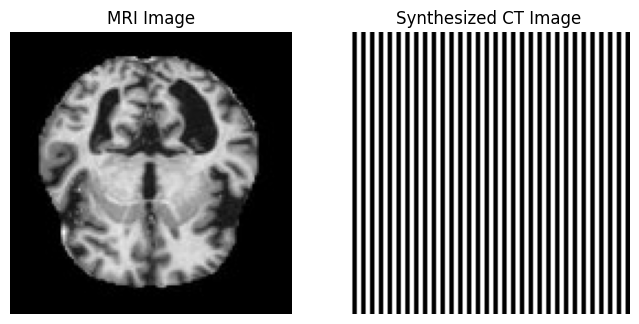

In [14]:
# Test the Generator
G.eval()
with torch.no_grad():
    mri_images = next(iter(dataloader))
    mri_images = mri_images.to(device)
    fake_ct = G(mri_images)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(mri_images[0].cpu().squeeze(), cmap='gray')
    plt.title("MRI Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(fake_ct[0].cpu().squeeze(), cmap='gray')
    plt.title("Synthesized CT Image")
    plt.axis('off')
    plt.show()

# NEW

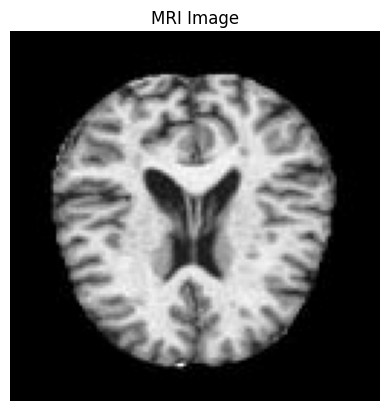

In [15]:
# Load the MRI dataset
mri_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (grayscale, 1 channel)
])

# Custom Dataset class for MRI
class MRIDataset(Dataset):
    def __init__(self, mri_dataset, transform=None):
        self.mri_dataset = mri_dataset
        self.transform = transform

    def __len__(self):
        return len(self.mri_dataset)

    def __getitem__(self, idx):
        mri_image = self.mri_dataset[idx]['image']
        if not isinstance(mri_image, Image.Image):
            mri_image = Image.fromarray(np.array(mri_image))

        if self.transform:
            mri_image = self.transform(mri_image)

        return mri_image

# Create dataset and dataloader
dataset = MRIDataset(mri_dataset, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Visualize a sample
mri_img = dataset[0]
plt.imshow(mri_img.squeeze(), cmap='gray')
plt.title("MRI Image")
plt.axis('off')
plt.show()

In [16]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # Encoder
        self.enc1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
        self.enc2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.enc4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)

        # Decoder with skip connections
        self.dec4 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.dec3 = nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1)
        self.dec2 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1)
        self.dec1 = nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1)

        self.norm = nn.InstanceNorm2d
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Encoder
        e1 = self.relu(self.norm(64)(self.enc1(x)))
        e2 = self.relu(self.norm(128)(self.enc2(e1)))
        e3 = self.relu(self.norm(256)(self.enc3(e2)))
        e4 = self.relu(self.norm(512)(self.enc4(e3)))

        # Decoder with skip connections
        d4 = self.relu(self.norm(256)(self.dec4(e4)))
        d4 = torch.cat([d4, e3], dim=1)  # Skip connection
        d3 = self.relu(self.norm(128)(self.dec3(d4)))
        d3 = torch.cat([d3, e2], dim=1)  # Skip connection
        d2 = self.relu(self.norm(64)(self.dec2(d3)))
        d2 = torch.cat([d2, e1], dim=1)  # Skip connection
        d1 = self.dec1(d2)
        return self.tanh(d1)

# Initialize generators
G_mri_to_ct = UNetGenerator().to(device)  # MRI -> CT
G_ct_to_mri = UNetGenerator().to(device)  # CT -> MRI (for cycle consistency)

In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 128x128 -> 64x64
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),  # 8x8 -> 8x8
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [21]:
# Initialize discriminators
D_app_ct = Discriminator(in_channels=1).to(device)  # Appearance discriminator for CT domain
D_str_ct = Discriminator(in_channels=2).to(device)  # Structure discriminator (MRI + CT)
D_app_mri = Discriminator(in_channels=1).to(device)  # Appearance discriminator for MRI domain
D_str_mri = Discriminator(in_channels=2).to(device)  # Structure discriminator (CT + MRI)

In [22]:
# Labels with smoothing
real_label = torch.full((batch_size, 1, 8, 8), 0.9).to(device)
fake_label = torch.full((batch_size, 1, 8, 8), 0.1).to(device)

In [18]:
# Loss functions
adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# Generate pseudo-CT (simulated CT domain) using edge detection
def generate_pseudo_ct(mri):
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).to(device)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).to(device)
    sobel_x = sobel_x.view(1, 1, 3, 3)
    sobel_y = sobel_y.view(1, 1, 3, 3)

    edge_x = F.conv2d(mri, sobel_x, padding=1)
    edge_y = F.conv2d(mri, sobel_y, padding=1)
    edges = torch.sqrt(edge_x**2 + edge_y**2)
    # Intensity thresholding to mimic bone structures
    pseudo_ct = torch.where(mri > 0.5, edges, mri * 0.2)
    return torch.tanh(pseudo_ct)

# Structure loss (compare edges of fake CT with edges of pseudo-CT)
def structure_loss(fake_ct, pseudo_ct):
    fake_edges = generate_pseudo_ct(fake_ct)
    real_edges = generate_pseudo_ct(pseudo_ct)
    return l1_loss(fake_edges, real_edges)

In [23]:
# Optimizers
optimizer_G = optim.Adam(list(G_mri_to_ct.parameters()) + list(G_ct_to_mri.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_app = optim.Adam(list(D_app_ct.parameters()) + list(D_app_mri.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_str = optim.Adam(list(D_str_ct.parameters()) + list(D_str_mri.parameters()), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 100
lambda_cycle = 10.0
lambda_str = 5.0

for epoch in range(num_epochs):
    for i, mri_images in enumerate(dataloader):
        mri_images = mri_images.to(device)
        batch_size = mri_images.size(0)

        # Generate pseudo-CT
        with torch.no_grad():
            real_ct = generate_pseudo_ct(mri_images)

        # Labels with smoothing
        real_label = torch.full((batch_size, 1, 8, 8), 0.9).to(device)
        fake_label = torch.full((batch_size, 1, 8, 8), 0.1).to(device)

        # --- Train Discriminators ---
        # Appearance Discriminator (CT domain)
        optimizer_D_app.zero_grad()
        fake_ct = G_mri_to_ct(mri_images)
        real_pred_app_ct = D_app_ct(real_ct)
        fake_pred_app_ct = D_app_ct(fake_ct.detach())
        loss_D_app_ct = (adversarial_loss(real_pred_app_ct, real_label) + adversarial_loss(fake_pred_app_ct, fake_label)) * 0.5

        # Appearance Discriminator (MRI domain)
        fake_mri = G_ct_to_mri(real_ct)
        real_pred_app_mri = D_app_mri(mri_images)
        fake_pred_app_mri = D_app_mri(fake_mri.detach())
        loss_D_app_mri = (adversarial_loss(real_pred_app_mri, real_label) + adversarial_loss(fake_pred_app_mri, fake_label)) * 0.5

        loss_D_app = loss_D_app_ct + loss_D_app_mri
        loss_D_app.backward()
        optimizer_D_app.step()

        # Structure Discriminator (CT domain)
        optimizer_D_str.zero_grad()
        real_input_str_ct = torch.cat([mri_images, real_ct], dim=1)
        fake_input_str_ct = torch.cat([mri_images, fake_ct.detach()], dim=1)
        real_pred_str_ct = D_str_ct(real_input_str_ct)
        fake_pred_str_ct = D_str_ct(fake_input_str_ct)
        loss_D_str_ct = (adversarial_loss(real_pred_str_ct, real_label) + adversarial_loss(fake_pred_str_ct, fake_label)) * 0.5

        # Structure Discriminator (MRI domain)
        real_input_str_mri = torch.cat([real_ct, mri_images], dim=1)
        fake_input_str_mri = torch.cat([real_ct, fake_mri.detach()], dim=1)
        real_pred_str_mri = D_str_mri(real_input_str_mri)
        fake_pred_str_mri = D_str_mri(fake_input_str_mri)
        loss_D_str_mri = (adversarial_loss(real_pred_str_mri, real_label) + adversarial_loss(fake_pred_str_mri, fake_label)) * 0.5

        loss_D_str = loss_D_str_ct + loss_D_str_mri
        loss_D_str.backward()
        optimizer_D_str.step()

        # --- Train Generators ---
        optimizer_G.zero_grad()
        fake_ct = G_mri_to_ct(mri_images)
        fake_mri = G_ct_to_mri(real_ct)

        # Adversarial losses
        pred_fake_app_ct = D_app_ct(fake_ct)
        pred_fake_app_mri = D_app_mri(fake_mri)
        loss_G_app_ct = adversarial_loss(pred_fake_app_ct, real_label)
        loss_G_app_mri = adversarial_loss(pred_fake_app_mri, real_label)

        fake_input_str_ct = torch.cat([mri_images, fake_ct], dim=1)
        fake_input_str_mri = torch.cat([real_ct, fake_mri], dim=1)
        pred_fake_str_ct = D_str_ct(fake_input_str_ct)
        pred_fake_str_mri = D_str_mri(fake_input_str_mri)
        loss_G_str_ct = adversarial_loss(pred_fake_str_ct, real_label)
        loss_G_str_mri = adversarial_loss(pred_fake_str_mri, real_label)

        # Cycle-consistency losses
        rec_mri = G_ct_to_mri(fake_ct)
        rec_ct = G_mri_to_ct(fake_mri)
        loss_cycle_mri = l1_loss(rec_mri, mri_images)
        loss_cycle_ct = l1_loss(rec_ct, real_ct)

        # Structure loss
        loss_str = structure_loss(fake_ct, real_ct)

        # Total Generator Loss
        loss_G = (loss_G_app_ct + loss_G_app_mri + loss_G_str_ct + loss_G_str_mri +
                  lambda_cycle * (loss_cycle_mri + loss_cycle_ct) + lambda_str * loss_str)
        loss_G.backward()
        optimizer_G.step()

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                  f"Loss_D_app: {loss_D_app.item():.4f} Loss_D_str: {loss_D_str.item():.4f} Loss_G: {loss_G.item():.4f}")

    # Save models
    torch.save(G_mri_to_ct.state_dict(), f'CycleSGAN_G_mri_to_ct_epoch_{epoch+1}.pth')

ValueError: Using a target size (torch.Size([4, 1, 8, 8])) that is different to the input size (torch.Size([4, 1, 7, 7])) is deprecated. Please ensure they have the same size.